In [1]:
import re
import os
import torch
import json
import numpy as np
import pandas as pd
import seaborn as sns
import transformers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from typing import Callable, Union, Tuple
from tqdm.notebook import tqdm
from collections import Counter
from torch import nn
from catalyst import dl
from catalyst.callbacks.periodic_loader import PeriodicLoaderCallback
from langdetect import detect
from easse.sari import corpus_sari
from rouge import Rouge 

from utils.dataset_utils import extract_com8text_from_tgt, extract_text8docs_from_src
from utils.dataset_utils import EditDataset, get_tgt, get_src, COM_SEP, TEXT_SEP_SRC, TEXT_SEP_TGT, DOCS_SEP
from utils.dataset_utils import ExplainDataset, get_tgt_explain, get_src_explain
from utils.metrics_utils import PeerEditMetricsCallback, PeerExplainMetricsCallback
from utils.config import Config


DOCS_DIR = 'data'
PAGES_DIR = 'data'

In [2]:
CONFIG = Config()
CONFIG.seed = 1337

In [3]:
import random

random.seed(CONFIG.seed)
os.environ['PYTHONHASHSEED'] = str(CONFIG.seed)
np.random.seed(CONFIG.seed)
torch.manual_seed(CONFIG.seed)
torch.cuda.manual_seed(CONFIG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Data preparing

In [4]:
mp = json.load(open(r"data/column_mapper.json"))

train = pd.read_json(r'data/train.json')
train.set_axis(mp.values(), axis='columns', inplace=True)

test = pd.read_json(r'data/test.json')
test.set_axis(mp.values(), axis='columns', inplace=True)

val = pd.read_json(r'data/val.json')
val.set_axis(mp.values(), axis='columns', inplace=True)
val1 = val.sample(600)

In [5]:
train.head()

,obj_id,old_text,new_text,comment,docs,diff,title,search_queries,counter_found_docs,section_name,is_good,docs_processed
0,13807,People Who Fear People was another project tha...,"People Who Fear People Variety, August 17th, 1...",/* People Who Fear People (1999) */ Added refe...,"Maria Pitillo (born January 8, 1966) is an Ame...","Variety, August 17th, 1999 Page 5",Maria Pitillo,[Maria Pitillo People Who Fear People (1999) ...,[28],People Who Fear People (1999),True,"DOC0: Maria Pitillo (born January 8, 1966) is ..."
1,1431,Thank you for signing my signbook. :) <3 Tinkl...,Thank you for signing my signbook. :) <3 Tinkl...,/* Thank You */ re,Councilmember Antonio López. 584 likes. Welcom...,\n:your welcome,Antonio Lopez,[Antonio Lopez Thank You \n:your welcome],[24],Thank You,True,DOC0: Councilmember Antonio López. 584 likes. ...
2,1362,Mark Ward may refer to:\n* Mark Ward (football...,Mark Ward may refer to:\n* Mark Ward (football...,Added in Mark Ward Sinn Féin TD for Dublin Mid...,Email me. Spokesperson for Mental Health. Mark...,\n* Mark Ward Sinn Féin TD for Dublin Mid West,Mark Ward,[Mark Ward \n* Mark Ward Sinn Féin TD for Dubl...,[28],,True,DOC0: Email me. Spokesperson for Mental Health...
3,10057,National Schools Tree Day is held on the last ...,National Schools Tree Day is held on the last ...,Removed footnote reference to wikipedia article,"While every day can be Tree Day, we dedicate c...",(See Planet Ark).,Arbor Day,[Arbor Day Australia (See Planet Ark).],[27],Australia,True,"DOC0: While every day can be Tree Day, we dedi..."
4,4566,* Bea Alonzo as Architect Basha-Belinda Eugeni...,* Bea Alonzo as Architect Basha-Belinda Eugeni...,/* Cast */ Added links,Top cast ; John Lloyd Cruz · Popoy ; Bea Alonz...,"Rodolfo """,A Second Chance (2015 film),"[A Second Chance (2015 film) Cast Rodolfo ""]",[27],Cast,True,DOC0: Top cast ; John Lloyd Cruz · Popoy ; Bea...


In [6]:
CONFIG.src_max_len = 1024
CONFIG.tgt_max_len = 128
CONFIG.pretrained = 't5-small'
CONFIG.batch_size = 4

tokenizer = T5TokenizerFast.from_pretrained(CONFIG.pretrained, model_max_length=CONFIG.src_max_len)

In [7]:
idx = 1
el_idx = train.iloc[idx]

docs = el_idx['docs_processed']
comment = el_idx['comment']
old_text = el_idx['old_text']
new_text = el_idx['new_text']

print(f'Old text: {old_text}\n\n')
print(f'New text: {new_text}\n\n')
print(f'Comment: {comment}\n\n')
print(f'Docs: {docs}\n\n')

src = get_src_explain(el_idx)
tgt = get_tgt_explain(el_idx)

print(f'Src: {src}\n\n')
print(f'Tgt: {tgt}\n\n')

Old text: Thank you for signing my signbook. :) <3 Tinkleheimer TALK!! 03:12, 10 June 2008 (UTC)


New text: Thank you for signing my signbook. :) <3 Tinkleheimer TALK!! 03:12, 10 June 2008 (UTC)
:your welcome


Comment: /* Thank You */ re


Docs: DOC0: Councilmember Antonio López. 584 likes. Welcome to my official government page for my office as councilman for the City of East Palo Alto. As its newest DOC1: Nov 24, 2021 — Hello and welcome to For The Wild Podcast, I'm Ayana Young.. Well, Antonio, thank you so much for spending time with us on For The Wild DOC2: Gruau - fashion illustrations. My scans. You're welcome to post these elsewhere but please consider linking back to my flickr. Thank you DOC3: Thank you to our former council for all… · Very excited to be a part of the… · Dear Friends, On Saturday, January… DOC4: Learn more about Antonio Lopez's work experience, education, connections & more by visiting their profile on LinkedIn.. Thank you for the award DOC5: Jan 5, 2021 — Ea

**Make dataset**

In [8]:
ds_train = ExplainDataset(train, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)
ds_val = ExplainDataset(val1, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)
ds_val_full = ExplainDataset(val, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)

**Len distribution**

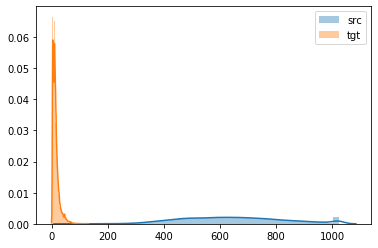

In [9]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in ds_train:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.distplot(arr_src, label='src');
plt.legend();
sns.distplot(arr_tgt, label='tgt');
plt.legend();

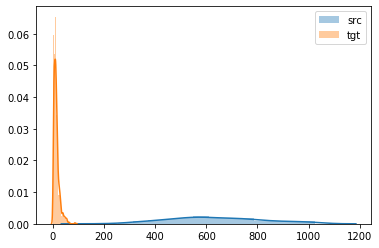

In [10]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in ds_val:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.distplot(arr_src, label='src');
plt.legend();
sns.distplot(arr_tgt, label='tgt');
plt.legend();

In [11]:
idx_num = 0
src_text = tokenizer.decode(ds_train[idx_num][0]['input_ids'], skip_special_tokens=True)
tgt_text = tokenizer.decode(ds_train[idx_num][1]['input_ids'], skip_special_tokens=True)

In [12]:
print(f'{src_text}\n\n{tgt_text}')

people who fear people was another project that didn't get off the board, however, jon cryer, a partners co-star, was also penciled in to participate in this project. djfitzgerald111 (talk) 16:31, 17 november 2013 (utc) TEXT_SEP people who fear people variety, august 17th, 1999 page 5 was another project that didn't get off the board, however, jon cryer, a partners co-star, was also penciled in to participate in this project. djfitzgerald111 (talk) 16:31, 17 november 2013 (utc) DOCS_SEP doc0: maria pitillo (born january 8, 1966) is an american retired actress. she has starred in films and on television, most notably as audrey timmonds in godzilla (1998).. people who fear people (1999) w/jon cryer, directed by james burrows. jon cryer, a partners co-star, participated in this project doc1: aug 17, 1999 12:00am pt abc sets appointment for cryers couch trip pilot astin, krumholtz, campbell fear people by cynthia littleton abc is moving forward with a pilot for paramount doc2: 1999 - provi

## Model training

In [13]:
loaders = {
    'train': torch.utils.data.DataLoader(ds_train, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True),
    'valid_full': torch.utils.data.DataLoader(ds_val_full, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=False),
    'valid_subset': torch.utils.data.DataLoader(ds_val, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=False)
}

In [16]:
class ExplainModel(nn.Module):
    def __init__(self, 
                 pretrained: transformers.modeling_utils.PreTrainedModel, 
                 config: Config):
        super(ExplainModel, self).__init__()
        self.pretrained = pretrained
        

    def forward(self, 
                x: Tuple[torch.Tensor, torch.Tensor]):
        src, tgt = x
        
        tgt[tgt == 0] == -100
        
        loss = self.pretrained(
            input_ids = src,
            attention_mask = (src != 0).float(),
            labels=tgt,
        ).loss
        return loss
    
    
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        
    def forward(self, pred, tgt):
        return pred

In [17]:
model = ExplainModel(
    T5ForConditionalGeneration.from_pretrained(CONFIG.pretrained),
    CONFIG
)
CONFIG.optimizer = 'Adam(lr=0.0001)'
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

CONFIG.name = f'{CONFIG.pretrained}'
CONFIG.description = f'{CONFIG.name} p(comment | x_t, x_t+1, doc)'
CONFIG.group = "wiki_explain"

In [18]:
!rm -rf ./models/"{CONFIG.description}"

In [19]:
CONFIG.n_epochs = 40

In [20]:
METRIC_LIST = [
    'full__exact_match@1',
    'full__exact_match@5'
]   

In [ ]:
runner = dl.SupervisedRunner()

wandb_logger = dl.WandbLogger(project="interactive_lm", 
                              name=CONFIG.name, 
                              group=CONFIG.group)

runner.train(
    loaders=loaders,
    model=model,
    criterion=Criterion(),
    optimizer=optimizer,
    num_epochs=CONFIG.n_epochs,
    callbacks=[
        PeriodicLoaderCallback(
            valid_loader_key='valid_full',
            valid_metric_key='loss',
            minimize=True,
            **{'valid_full': 5}
        ),
        PeerExplainMetricsCallback(METRIC_LIST, tokenizer),
    ],
    loggers={'wandb': wandb_logger},
    logdir=f'./models/{CONFIG.description}',
    valid_loader='valid_subset',
    valid_metric='loss',
    minimize_valid_metric=True,
    verbose=True,
#     check=True,
#     cpu=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anton-sh. Use `wandb login --relogin` to force relogin


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (1/40) loss: 1.649361021394529 | loss/mean: 1.649361021394529 | loss/std: 0.6030974367873485 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid_subset (1/40) full__exact_match@1: 0.013333 | full__exact_match@1/std: 0.056221 | full__exact_match@5: 0.028333 | full__exact_match@5/std: 0.084414 | loss: 1.2900743212302532 | loss/mean: 1.2900743212302532 | loss/std: 0.5006436280814154 | lr: 0.0001 | momentum: 0.9
* Epoch (1/40) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (2/40) loss: 1.409217166704521 | loss/mean: 1.409217166704521 | loss/std: 0.512855662655884 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid_subset (2/40) full__exact_match@1: 0.015 | full__exact_match@1/std: 0.059421 | full__exact_match@5: 0.03 | full__exact_match@5/std: 0.086289 | loss: 1.2147189020117133 | loss/mean: 1.2147189020117133 | loss/std: 0.49655456094779366 | lr: 0.0001 | momentum: 0.9
* Epoch (2/40) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (3/40) loss: 1.3205825111484055 | loss/mean: 1.3205825111484055 | loss/std: 0.5032721566526529 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid_subset (3/40) full__exact_match@1: 0.023333 | full__exact_match@1/std: 0.07831 | full__exact_match@5: 0.043333 | full__exact_match@5/std: 0.099021 | loss: 1.1831096577644349 | loss/mean: 1.1831096577644349 | loss/std: 0.5020773595445669 | lr: 0.0001 | momentum: 0.9
* Epoch (3/40) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (4/40) loss: 1.2602585762019796 | loss/mean: 1.2602585762019796 | loss/std: 0.4848418918210503 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid_subset (4/40) full__exact_match@1: 0.025 | full__exact_match@1/std: 0.075063 | full__exact_match@5: 0.048333 | full__exact_match@5/std: 0.106925 | loss: 1.1638787601391467 | loss/mean: 1.1638787601391467 | loss/std: 0.5029170623074395 | lr: 0.0001 | momentum: 0.9
* Epoch (4/40) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


CONFIG.beam_size = 1

device = runner.engine.device
runner.model.eval()
with torch.no_grad():
    for i in [0, 1, 2]:
        src_, tgt_ = ds_train[i]
        src_inp = torch.tensor(src_['input_ids']).view(1,-1).to(runner.engine.device)
        generated = runner.model.pretrained.generate(src_inp,
                                              attention_mask=(src_inp != 0).float().to(runner.engine.device),
                                            # pad_token_id=tokenizer.pad_token_id,
                                            # bos_token_id=tokenizer.bos_token_id,
                                            # eos_token_id=tokenizer.eos_token_id,
                                              num_beams=CONFIG.beam_size,
                                              num_return_sequences=CONFIG.beam_size,
                                              max_length=1000
        )
        
        tgt_full = tokenizer.decode(tgt_['input_ids'], skip_special_tokens=True).strip()
        tgt_comment, tgt_text = extract_com8text_from_tgt(tgt_full)

        src_full = tokenizer.decode(src_['input_ids'], skip_special_tokens=True).strip()
        src_text, _ = extract_text8docs_from_src(src_full)
        
        
        print(f'\n\n----------------------------\t QUERY {i}\t ----------------------------\n')
        print(f'Src query:\n {src_text}')
        print(f'\nTgt query:\n {tgt_text}')
        print(f'\nTgt comment:\n {tgt_comment}')
        
        print(f'\n\n----------------------------\t GENERATED\t ----------------------------\n')

        pred_full = []
        pred_texts = []
        pred_comments = []
        for j in range(CONFIG.beam_size):
            to_gen = generated[j]
            gen_text = tokenizer.decode(to_gen, skip_special_tokens=True)
            com_prediction, text_prediction = extract_com8text_from_tgt(gen_text)
            
            pred_full.append(gen_text)
            pred_texts.append(text_prediction)
            pred_comments.append(com_prediction)
            
            print(f'{j} TEXT:\n{text_prediction}\n')
            print(f'{j} COMMENT:\n{com_prediction}\n\n')
        
        print('Text sari:', sari_one(src_text, tgt_text, pred_texts))
        print('Com em:', topN_diff_exact_match_one('', tgt_comment, pred_comments))
        print('Full em:', topN_diff_exact_match_one(src_full, tgt_full, pred_full))
        print('Text em:', topN_diff_exact_match_one(src_text, tgt_text, pred_texts))
        print('Rouge text:', rouge_one(src_text, tgt_text, pred_texts)['rouge-1'])